![AES-774 Masthead](http://kyrill.ias.sdsmt.edu/wjc/eduresources/AES_744_Masthead.png)

# WRF Namelist Reading and Plotting Script

## Overview

There are a couple resources that now help users define spatial regions for WRF by pointing and clicking on a map interface.  One is an interface that runs through [QGIS](https://qgis.org/en/site/forusers/download.html), an open source GIS resource.  (I recommend getting the Long-Term Release [LTR] version.)  The tool is [GIS4WRF](https://gis4wrf.github.io). I was skeptical of it at first, it's a little clunky and does a lot more than I personally need, but I find it to be an improvement over previous GUI WRF setups.  Specifically the GIS4WRF build the domains from the innermost domains outward which provides far more precision than other domain, creating tools.

But to make simple professional plots, you may want another resource.

This script presumes that you already have a namelist.wps file and you can cut and paste the critical contents of the file, and make some small format tweaks for it to work.

It will then render the domains onto the native WRF projection (or other projection, e.g., Mercator, or "Plate Carrée" (aka "Geographic" or "Lat-Lon").  

You have the option to also have map backgrounds to contexutalize your selected region w.r.t. topography, places of interest, roads, rivers, water bodies, etc.

## Libraries

For this resource we will need the following libraries.


* [NumPy](https://numpy.org): our standard numerical manager in python
* [MatPlotLib](https://matplotlib.org)'s PyPlot and a few other features
* [CartoPy](https://scitools.org.uk/cartopy/docs/latest/): A map projection library.  We are specifically requesting the following sublibaries
   *  [CartoPy.crs](https://scitools.org.uk/cartopy/docs/latest/reference/crs.html): [Cartopy's Coordiate Reference System (CRS)](https://en.wikipedia.org/wiki/Spatial_reference_system) operators.  This is the information needed to draw the various projection.
   *  [CartoPy.feature](https://scitools.org.uk/cartopy/docs/latest/reference/feature.html): Cartopy's Feature Plotting Interface
   *  [CartoPy.io.img_tiles](https://scitools.org.uk/cartopy/docs/v0.16/cartopy/io/img_tiles.html): Access to Maping Tiles
   *  [CartoPy.mpl](https://scitools.org.uk/cartopy/docs/latest/reference/matplotlib.html): Cartopy Matplotlib Interface
* [wrf-python](https://wrf-python.readthedocs.io/en/latest): the WRF-Python Library (we probably could do this in a more clever way but since you probably already have it installed, let's aim for maximum satisfaction with minimal effort).



In [36]:
##############################################
#
# Library
#

import numpy                as np
import matplotlib.pyplot    as plt
import mpl_toolkits         as mpl

import cartopy.crs          as ccrs  
import cartopy.feature      as cfeature
import cartopy.io.img_tiles as cimgt
import cartopy.mpl          as cmpl

import wrf                  as wrf 

#
##############################################

## Import Name List Information

We are assuming that you already have a *namelist.wps* file ready and you are looking for a way to create a professional map out of what you already have.

Rather than read the *namelist.wps* file we can just cut ansd paste some critical parameters
*  parent_grid_ratio
*  i_parent_start & j_parent_start
*  e_we & e_sn
*  dx & dy
*  map_proj
*  ref_lat, ref_lon, stand_lon
*  truelat1, truelat2

In [2]:
##############################################
#
# Enter Expected Values from your Namelist Files
#

parent_grid_ratio = [1,     3,    3]

i_parent_start    = [1,    44,   40]
j_parent_start    = [1,    51,   30]

e_we              = [150,   190,  169]
e_sn              = [150,   148,  190]

dx                = 9000.
dy                = 9000.


map_proj          = 'lambert'


ref_lat           = 44.47
ref_lon           = -102.75



truelat1          = 44.47
truelat2          = 44.47

stand_lon         = -102.75

#
##############################################

## Generate Coordinate Reference System (CRS)

Mapping in Python is done by declaring a [Coordinate Reference System (CRS)](https://en.wikipedia.org/wiki/Spatial_reference_system).  

[Cartopy has a resource](https://scitools.org.uk/cartopy/docs/v0.15/crs/index.html) for this that you can manually create, but we will be using a resource from wrf-python to calculate the CRS for a given projection using the information provided in the namelist file from above.

These supported projections for this script are...

*  [wrf.LambertConformal()](https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.LambertConformal.html): Ideal for Middle Latitudes
*  [wrf.Mercator()](https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.Mercator.html): Ideal for the Tropics (and can also be used to represent the full Tropical Channel.
*  [wrf.PolarStereographic()](https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.PolarStereographic.html): Ideal for Higher Latitudes and the Polar Regions
*  [wrf.LatLon()](https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.LatLon.html): Which can be used for global-scale domains.

(This script does not support the rotated lat-lon framework in WRF)

All of the above resources will export a wrf.WrfProj object that can be converted into a [Cartopy](https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.WrfProj.cartopy.html), [PROJ.4](https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.WrfProj.proj4.html), or [CF-Metadata Projection Variable](https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.WrfProj.cf.html) format.  (Each of the three will be demonstrated below, but we will only use the Cartopy CRS object.)

Note: this script will also require the use of a Latitude-Longitude (a.k.a "Plate Carrée") projection.


In [25]:
##############################################
#
# Generate Coordinate Reference System
#

#
# Calculate the MOAD Center Latitude 
#  (MOAD = Mother of All Domains)
#  This is the true latitude of the (0,0) 
#  eastings/northings projected coordinate.
#

moad_cen_lat = np.average([truelat1,
                           truelat2])

#
# Pole Latitutde and Longitude 
#   (needed even for Mercator, Lat-Lon, 
#    and Lambert Projections)
#

if (ref_lat >=0):
    pole_lat = 90
else:
    pole_lat = -90.
    
#
# Package as a WRFProj Object
#

if   (map_proj == 'lambert'):
     wrf_projection_data = wrf.LambertConformal(TRUELAT1     =  truelat1,
                                                TRUELAT2     =  truelat2,
                                                MOAD_CEN_LAT = moad_cen_lat,
                                                STAND_LON    =    stand_lon,
                                                POLE_LAT     =     pole_lat,
                                                POLE_LON     =          0.0)
        
elif (map_proj == 'polar'):
    wrf_projection_data = wrf.PolarStereographic(TRUELAT1     =     truelat1,
                                                 TRUELAT2     =     truelat2,
                                                 MOAD_CEN_LAT = moad_cen_lat,
                                                 STAND_LON    =    stand_lon,
                                                 POLE_LAT     =     pole_lat,
                                                 POLE_LON     =          0.0)


elif (map_proj == 'mercator'):
    wrf_projection_data = wrf.Mercator(TRUELAT1     =     truelat1,
                                       TRUELAT2     =     truelat2,
                                       MOAD_CEN_LAT = moad_cen_lat,
                                       STAND_LON    =    stand_lon,
                                       POLE_LAT     =     pole_lat,
                                       POLE_LON     =          0.0)
else:
    wrf_projection_data = wrf.LatLon(TRUELAT1     =     truelat1,
                                     TRUELAT2     =     truelat2,
                                     MOAD_CEN_LAT = moad_cen_lat,
                                     STAND_LON    =    stand_lon,
                                     POLE_LAT     =     pole_lat,
                                     POLE_LON     =          0.0)

    
wrf_projection_data = wrf.LambertConformal(TRUELAT1     =     truelat1,
                                           TRUELAT2     =     truelat2,
                                           MOAD_CEN_LAT = moad_cen_lat,
                                           STAND_LON    =    stand_lon,
                                           POLE_LAT     =     pole_lat,
                                           POLE_LON     =          0.0)

#
# Display as a Specific Projection Product Type
#

wrf_crs   = wrf_projection_data.cartopy()
wrf_proj4 = wrf_projection_data.proj4()
wrf_cf    = wrf_projection_data.cf()

print("")
print("Display WrfProj Object")
display(wrf_projection_data)

print("")
print("Display Cartopy.CRS Map Object")
display (wrf_crs)

print("")
print("Display PROJ/PROJ4 String")
display (wrf_proj4)

print("")
print("Display Climate/Forecast Metadata Projection Dictionary")
display (wrf_cf)

#
# Generate Platte Carrée Projection
#

lonlat_crs = ccrs.PlateCarree(central_longitude = 0)

print("")
print("Display Cartopy.CRS Lat-Lon Object")
display(lonlat_crs)

#
##############################################


Display WrfProj Object


LambertConformal(stand_lon=-102.75, moad_cen_lat=44.47, truelat1=44.47, truelat2=44.47, pole_lat=90, pole_lon=0.0)


Display Cartopy.CRS Map Object


<Bound CRS: +proj=lcc +a=6370000.0 +b=6370000.0 +nadgrids=@nul ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown to WGS84
- method: NTv2
Datum: unknown using nadgrids=@null
- Ellipsoid: unknown
- Prime Meridian: Greenwich
Source CRS: unknown


Display PROJ/PROJ4 String


'+proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=44.47 +lat_2=44.47 +lat_0=44.47 +lon_0=-102.75 +nadgrids=@null'


Display Climate/Forecast Metadata Projection Dictionary


{'grid_mapping_name': 'lambert_conformal_conic',
 'standard_parallel': [44.47, 44.47],
 'longitude_of_central_meridian': -102.75,
 'latitude_of_projection_origin': 44.47,
 'earth_radius': 6370000.0}


Display Cartopy.CRS Lat-Lon Object


<Derived Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0 +to_m ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Getting Map Domain Extents

WRF uses an "Arakawa Staggered C-Grid" (shown below) to staggar its mass and momentum fields.  Thus for the Momemtum and Mass fields, they exist as three distinct grids (one for U, one for V, and one shared between mass points and W).

![Arakawa C-Grid](https://erf.readthedocs.io/en/latest/_images/Arakawa_1.png)

In [26]:
##############################################
#
# pull extents of each domain's arakawa-C grid
#

#
# Total Number of Domains to be Plotted
#

n_domains         = len(e_we)

#
# Calculate Grid Spacing for each domain
#

dx_arr            = np.empty(n_domains)
dy_arr            = np.empty(n_domains)

dx_arr[0] = dx
dy_arr[0] = dy

for i in range(1,n_domains):
    dx_arr[i] = dx_arr[i-1] / parent_grid_ratio[i]
    dy_arr[i] = dy_arr[i-1] / parent_grid_ratio[i]

#
# Pull the Center Point for the WRF Model domain (not the same
#   as the projection center where eastings and northings both
#   equal zero)
#
    
center_wrf = wrf_crs.transform_points(lonlat_crs,np.array(ref_lon),np.array(ref_lat))[0:1]


eastings_limits_ll_ur       = np.zeros([2,n_domains])
eastings_limits_ll_ur[:,0]  = center_wrf[0,0]+[- (e_we[0]-1)/2 * dx, 
                                                 (e_we[0]+1)/2 * dx]


northings_limits_ll_ur      = np.zeros([2,n_domains])
northings_limits_ll_ur[:,0] = center_wrf[0,1]+[- (e_sn[0]-1)/2 * dy, 
                                                 (e_sn[0]+1)/2 * dy]

print("------")
print("Domain ",(1), "Unstaggared Domain Corners (mass points)")
print(lonlat_crs.transform_points(wrf_crs,
                 np.array([ eastings_limits_ll_ur[0,0],
                            eastings_limits_ll_ur[0,0],  
                            eastings_limits_ll_ur[1,0],  
                            eastings_limits_ll_ur[1,0]]),
                 np.array([northings_limits_ll_ur[0,0], 
                           northings_limits_ll_ur[1,0], 
                           northings_limits_ll_ur[1,0], 
                           northings_limits_ll_ur[0,0]])))

eastings_100_wrf  = np.empty([100,n_domains], dtype=np.float32)
northings_100_wrf = np.empty([100,n_domains], dtype=np.float32)

box_x_wrf         = np.empty([400,n_domains], dtype=np.float32)
box_y_wrf         = np.empty([400,n_domains], dtype=np.float32)  

eastings_100_wrf[:,0]  = np.linspace(eastings_limits_ll_ur[0,0],
                                     eastings_limits_ll_ur[1,0],
                                     100)

northings_100_wrf[:,0] = np.linspace(northings_limits_ll_ur[0,0],
                                     northings_limits_ll_ur[1,0],
                                     100) 

box_x_wrf[  0:100,0] = eastings_100_wrf[:,0]
box_x_wrf[100:200,0] = eastings_limits_ll_ur[1,0]
box_x_wrf[200:300,0] = np.flip(eastings_100_wrf[:,0])
box_x_wrf[300:400,0] = eastings_limits_ll_ur[0,0]


box_y_wrf[  0:100,0] = northings_limits_ll_ur[0,0]
box_y_wrf[100:200,0] = northings_100_wrf[:,0]
box_y_wrf[200:300,0] = northings_limits_ll_ur[1,0]
box_y_wrf[300:400,0] = np.flip(northings_100_wrf[:,0]) 



for i in range(1, n_domains):
    eastings_limits_ll_ur[0,i]  = eastings_limits_ll_ur[0,i-1]  + (i_parent_start[i]-1)*dx_arr[i-1]
    eastings_limits_ll_ur[1,i]  = eastings_limits_ll_ur[0,i]  + (e_we[i]-1.0)*dx_arr[i] 

    northings_limits_ll_ur[0,i] = northings_limits_ll_ur[0,i-1] + (j_parent_start[i]-1)*dy_arr[i-1]
    northings_limits_ll_ur[1,i] = northings_limits_ll_ur[0,i] + (e_sn[i]-1.0)*dy_arr[i] 
    
    eastings_100_wrf[:,i]  = np.linspace(eastings_limits_ll_ur[0,i],
                                         eastings_limits_ll_ur[1,i],
                                         100)
    
    northings_100_wrf[:,i] = np.linspace(northings_limits_ll_ur[0,i],
                                         northings_limits_ll_ur[1,i],
                                         100)    
    
    box_x_wrf[  0:100,i] = eastings_100_wrf[:,i]
    box_x_wrf[100:200,i] = eastings_limits_ll_ur[1,i]
    box_x_wrf[200:300,i] = np.flip(eastings_100_wrf[:,i])
    box_x_wrf[300:400,i] = eastings_limits_ll_ur[0,i]

    
    box_y_wrf[  0:100,i] = northings_limits_ll_ur[0,i]
    box_y_wrf[100:200,i] = northings_100_wrf[:,i]
    box_y_wrf[200:300,i] = northings_limits_ll_ur[1,i]
    box_y_wrf[300:400,i] = np.flip(northings_100_wrf[:,i]) 
    
    print("------")
    print("Domain ",(i+1), "Unstaggared Domain Corners")

    print(lonlat_crs.transform_points(wrf_crs,
                                      np.array([ eastings_limits_ll_ur[0,i],
                                                 eastings_limits_ll_ur[0,i],
                                                 eastings_limits_ll_ur[1,i],
                                                 eastings_limits_ll_ur[1,i]]),
                                      np.array([northings_limits_ll_ur[0,i],
                                                northings_limits_ll_ur[1,i],
                                                northings_limits_ll_ur[1,i],
                                                northings_limits_ll_ur[0,i]])))


    



# Reproject the WRF Box Points.  You need to cut off the "z" mapping coordinates
#   from the two

#box_x_lonlat   =  lonlat_crs.transform_points(wrf_crs,box_x_wrf,box_y_wrf)[:,:,0]
#box_y_lonlat   =  lonlat_crs.transform_points(wrf_crs,box_x_wrf,box_y_wrf)[:,:,1]

print(" ")

#
##############################################

------
Domain  1 Unstaggared Domain Corners (mass points)
[[-110.38741629   38.16972481    0.        ]
 [-112.14806946   50.2250148     0.        ]
 [ -93.2269116    50.21572057    0.        ]
 [ -95.01067491   38.16217073    0.        ]]
------
Domain  2 Unstaggared Domain Corners
[[-106.2038233    42.43326086    0.        ]
 [-106.4464878    46.39531617    0.        ]
 [ -99.0535122    46.39531617    0.        ]
 [ -99.2961767    42.43326086    0.        ]]
------
Domain  3 Unstaggared Domain Corners
[[-104.80587308   43.25048556    0.        ]
 [-104.86624333   44.94982019    0.        ]
 [-102.73093049   44.96919394    0.        ]
 [-102.73147472   43.2693031     0.        ]]
 


## NOW we can make some pretty graphs

### A minimalist graph (just coasts and borders)

Now we can use the system to plot out domains. 

The option is here for you to use a separate map proj from the native WRF projection.  

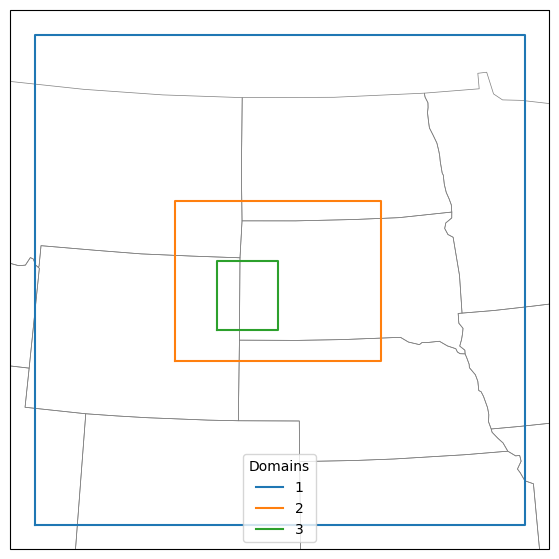

In [32]:
##############################################
#
# Make a plain line map
#

fig = plt.figure(figsize=(11, 7))

# add a plot element just one field aka the "Axes"

ax = fig.add_subplot(1,  # nrows
                     1,  # ncols 
                     1,  # index of figure you're installing
                     projection = wrf_crs) # cartopy CRS Projection


ax.plot(box_x_wrf[:,:],box_y_wrf[:,:], transform=wrf_crs)


ax.coastlines(linewidths =  0.75)

ax.add_feature(cfeature.STATES.with_scale('110m'), 
                   linewidths = 0.5,
                   facecolor  = 'none', 
                   edgecolor  = 'tab:gray')

plt.legend(np.linspace(1,n_domains,n_domains).astype("int"),
           title = "Domains")

plt.show()

#
##############################################

###  Maps With a Background (Google Maps)

[The Cartopy Input Output](https://scitools.org.uk/cartopy/docs/latest/reference/io.html) has resources for various map backgrounds.  The Google Maps collection is shown below.  

The resources for it is [cartopy.io.img_tiles.GoogleTiles()](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.io.img_tiles.GoogleTiles.html)

For the *style* keyword you can try ‘street’, ‘satellite’, ‘terrain’, and ‘only_streets’

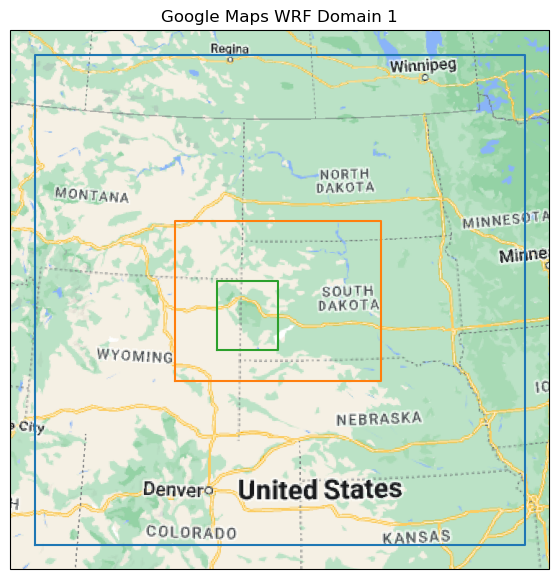

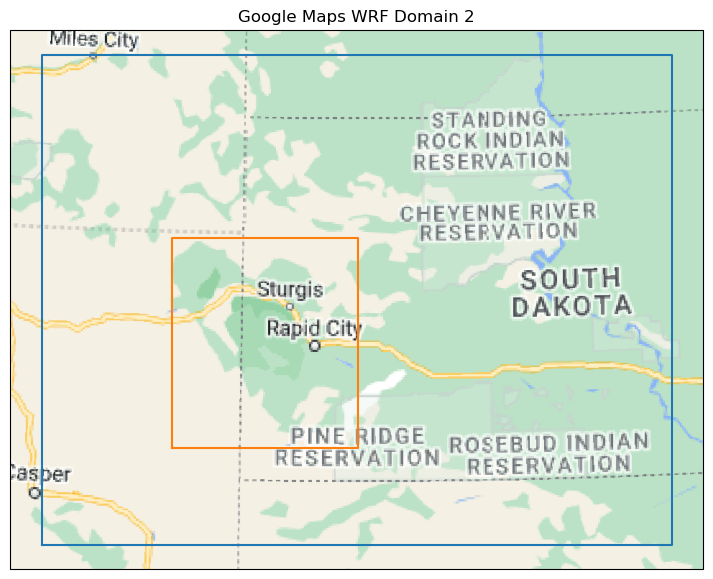

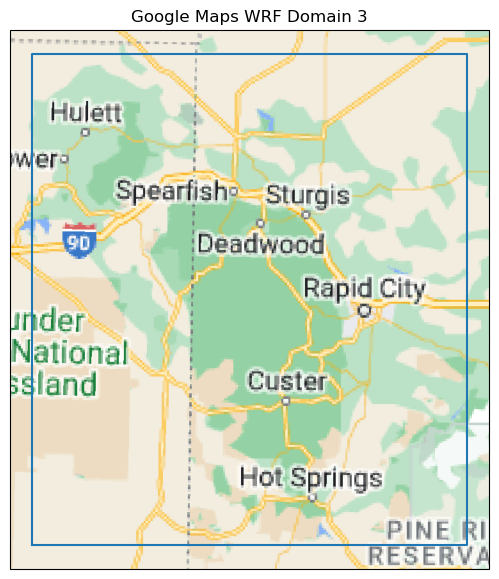

In [65]:
##############################################
#
# Make a map with google Maps
#

for i in range(0, n_domains) : 


    fig = plt.figure(figsize=(11, 7))

    # add a plot element just one field aka the "Axes"

    ax = fig.add_subplot(1,  # nrows
                         1,  # ncols 
                         1,  # index of figure you're installing
                         projection = wrf_crs) # cartopy CRS Projection

    
    tiler = cimgt.GoogleTiles(style='street')
    
    ax.add_image(tiler ,(i+8-3))
    
    plt.plot(box_x_wrf[:,i:], box_y_wrf[:,i:], transform=wrf_crs)


    
    plt.title("Google Maps WRF Domain " + str(i+1))



    plt.show()

#
##############################################

###  Maps With a Background (Open Street Maps)

And Open Street Maps's resource is [cartopy.io.img_tiles.OSM()](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.io.img_tiles.OSM.html)



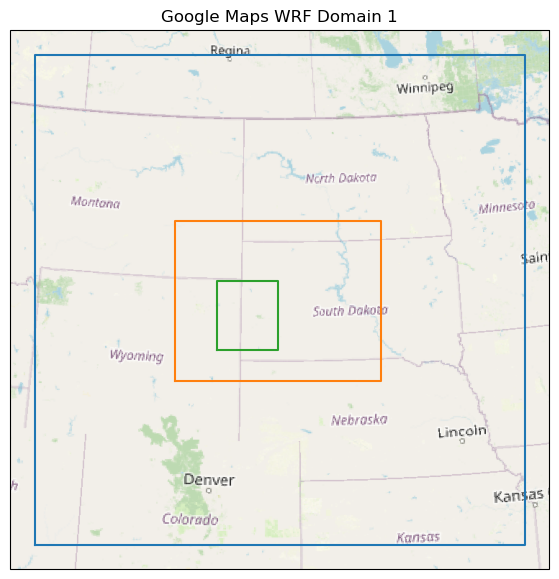

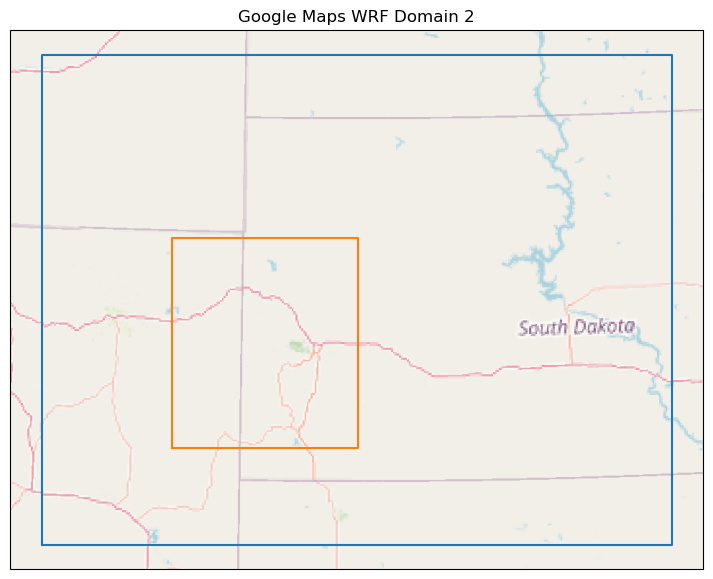

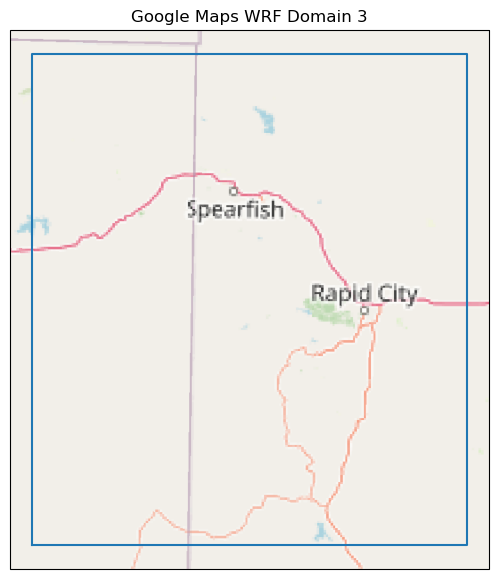

In [68]:
##############################################
#
# Make a map with google Maps
#

for i in range(0, n_domains) : 


    fig = plt.figure(figsize=(11, 7))

    # add a plot element just one field aka the "Axes"

    ax = fig.add_subplot(1,  # nrows
                         1,  # ncols 
                         1,  # index of figure you're installing
                         projection = wrf_crs) # cartopy CRS Projection

    
    tiler = cimgt.OSM()
    
    ax.add_image(tiler ,(i+8-3))
    
    plt.plot(box_x_wrf[:,i:], box_y_wrf[:,i:], transform=wrf_crs)


    
    plt.title("Google Maps WRF Domain " + str(i+1))



    plt.show()

#
##############################################

## Version Information

There was once a very handy tool that would print version information of the Python version, operating system, and the versions of the Python packages you are running. It leveraged a "magic" command in IPython (which is what lies beneath Jupyter and JuptyerLab notebooks).

The developer has moved on to other things but the resource still has a narrow but ~militant~ ernest fan base (myself included). The original doesn't work with versions of Python above 3.7. So a couple of us wrote some patches to fix it. You can access my version below following these instructions.

If you don't have GIT on your rig yet, you can fetch it via conda

```
conda install -y -v git
```
You can install it using the following command.
```
pip install git+https://github.com/wjcapehart/version_information 
```
### JupyterLab Caveat

For people using Jupyter Lab, the interface does not play well with this "magic" function. It basically exports it as a JSON object with clicky expander buttons. However if you "Export" your notebook as an HTML or PDF file you should get a reasonable looking exported document.

In [70]:
################################################################
#
# Loading Version Information
#

%load_ext version_information

%version_information version_information, numpy, matplotlib, cartopy, wrf

#
################################################################

Software versions
Python 3.9.13 64bit [Clang 13.0.1 ]
IPython 8.5.0
OS macOS 13.0 x86_64 i386 64bit
version_information 1.0.3
numpy 1.23.4
matplotlib 3.5.3
cartopy 0.21.0
wrf 1.3.4.1
Wed Nov 09 19:28:53 2022 MST